In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report


In [2]:
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    
    return projected, components, mean, centered_data

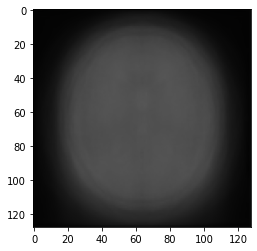

In [3]:
# Load the data and visualize the mean
data = np.load("Data_flattened.npy")
labels = np.load("Labels.npy")

mean = np.mean(data, axis=0)
mean = mean.reshape(128,128,3)
plt.imshow(mean)
plt.show()

Variance explained by reduced components -> 0.9000110551325976
Number of components -> 551
Dimension reduced by -> 98.87898763020834


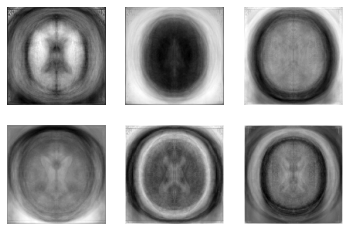

In [4]:
# Apply PCA if not generated.
# Skip to next cell if generated.

# shape of data = (number of samples, number of features)
# Each column is a particular pixel which is a feature

scaler = StandardScaler()
scaler.fit(data)
data_tranformed = scaler.transform(data)

pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(data_tranformed)

print(f"Variance explained by reduced components -> {np.sum(pca.explained_variance_ratio_)}")
print(f"Number of components -> {pca.n_components_}")
print(f"Dimension reduced by -> {100* (1 - pca.n_components_/data.shape[1])}")

# EigenBrains!

V = pca.components_
V = V.reshape(-1, 128, 128, 3)

plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(V[i, :, :, 0], cmap=plt.cm.gray)
    #plt.imsave("eigenbrain_" +str(i+1) + ".jpg", V[i, :, :, 0])
    plt.axis('off')
plt.show()

data_copy = data.copy()
data_copy = pca.transform(data_copy)
data_copy.shape

np.save("pca.npy", data_copy)

In [5]:
# Loading the saved pca features
data_copy = np.load("pca.npy")
labels = np.load("Labels.npy")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_copy, labels, test_size=0.2)
X_train.shape

(5618, 551)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train.flatten())
print(f"Training accuracy using random forest -> {accuracy_score(y_train, rfc.predict(X_train))} ")
print(f"Test accuracy using random forest -> {accuracy_score(y_test, rfc.predict(X_test))} ")
print(classification_report(y_test, rfc.predict(X_test)))

Training accuracy using random forest -> 1.0 
Test accuracy using random forest -> 0.9039145907473309 
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       399
         1.0       0.88      0.86      0.87       330
         2.0       0.86      0.83      0.85       327
         3.0       0.89      0.98      0.93       349

    accuracy                           0.90      1405
   macro avg       0.90      0.90      0.90      1405
weighted avg       0.90      0.90      0.90      1405



Training accuracy using SVM -> 0.9992880028479886 
Test accuracy using SVM -> 0.9338078291814946 
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       381
         1.0       0.93      0.90      0.92       347
         2.0       0.85      0.90      0.87       326
         3.0       0.97      0.98      0.98       351

    accuracy                           0.93      1405
   macro avg       0.93      0.93      0.93      1405
weighted avg       0.94      0.93      0.93      1405



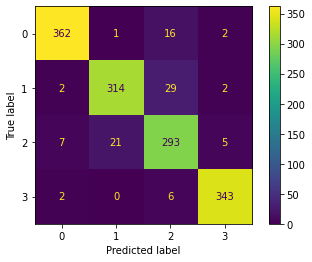

In [7]:
svc = make_pipeline(StandardScaler(), SVC(C=5,gamma='auto', max_iter=-1))
svc.fit(X_train, y_train.flatten())
print(f"Training accuracy using SVM -> {accuracy_score(y_train, svc.predict(X_train))} ")
print(f"Test accuracy using SVM -> {accuracy_score(y_test, svc.predict(X_test))} ")
print(classification_report(y_test, svc.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, svc.predict(X_test)))
disp.plot()
plt.show()

In [9]:
def neural_network_v2(input_shape):
    initializer = tf.keras.initializers.HeNormal()
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(inputs)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)    
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(1028, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

nn = neural_network_v2(X_train.shape[1])
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy())

epochs = 100
batch_size = 32

history = nn.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose = 1, validation_data=(X_test, y_test))

Epoch 1/100
176/176 [==============================] - 7s 19ms/step - loss: 1.6279 - accuracy: 0.3017 - val_loss: 1.1592 - val_accuracy: 0.5181
Epoch 2/100
176/176 [==============================] - 3s 18ms/step - loss: 1.2778 - accuracy: 0.4290 - val_loss: 1.0836 - val_accuracy: 0.5459
Epoch 3/100
176/176 [==============================] - 3s 19ms/step - loss: 1.0630 - accuracy: 0.5557 - val_loss: 1.1010 - val_accuracy: 0.5744
Epoch 4/100
176/176 [==============================] - 3s 18ms/step - loss: 0.9074 - accuracy: 0.6276 - val_loss: 1.0018 - val_accuracy: 0.6171
Epoch 5/100
176/176 [==============================] - 3s 17ms/step - loss: 0.8044 - accuracy: 0.6725 - val_loss: 0.9326 - val_accuracy: 0.6491
Epoch 6/100
176/176 [==============================] - 3s 17ms/step - loss: 0.7231 - accuracy: 0.7118 - val_loss: 0.8552 - val_accuracy: 0.6562
Epoch 7/100
176/176 [==============================] - 3s 18ms/step - loss: 0.6746 - accuracy: 0.7328 - val_loss: 0.7731 - val_accuracy:

In [10]:
acc = nn.evaluate(X_test, y_test, verbose = 1)
print(f"Best accuracy achieved = {acc[1]*100}")
print( np.argmax(nn.predict(X_test, batch_size = 1), axis = 1))
print(classification_report(y_test, np.argmax(nn.predict(X_test, batch_size = 1), axis = 1)))

44/44 [==============================] - 0s 5ms/step - loss: 0.4284 - accuracy: 0.9167
Best accuracy achieved = 91.67259931564331
[2 3 3 ... 1 1 2]
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       399
         1.0       0.87      0.92      0.89       330
         2.0       0.86      0.83      0.85       327
         3.0       0.95      0.98      0.97       349

    accuracy                           0.92      1405
   macro avg       0.91      0.92      0.91      1405
weighted avg       0.92      0.92      0.92      1405



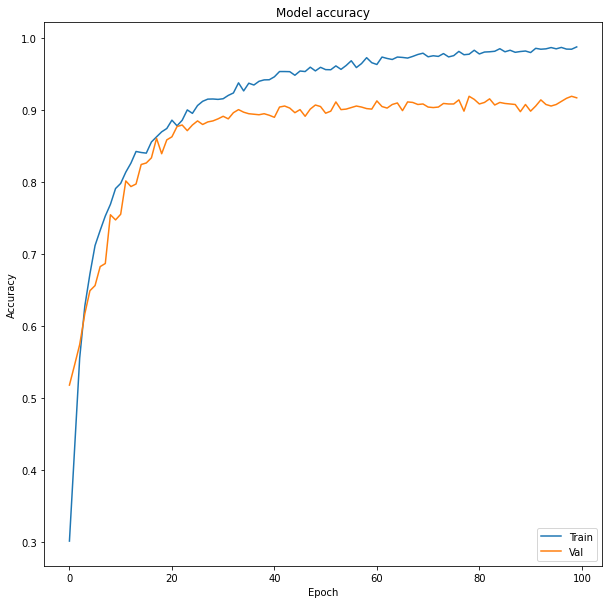

In [11]:
plt.figure(figsize =(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()